In [129]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime,Trace
from obspy.geodetics.base import gps2dist_azimuth,kilometers2degrees
from obspy.taup import TauPyModel
from obspy.signal.rotate import rotate_ne_rt
import matplotlib.pyplot as plt 
from obspy.signal.filter import envelope
import numpy as np
client = Client("IRIS")
model = TauPyModel(model="iasp91")

In [2]:
starttime = UTCDateTime("2015-02-11")
endtime = UTCDateTime("2015-02-12")
Cata = client.get_events(starttime=starttime, endtime=endtime,
                        minmagnitude=6.5,latitude =41.115,longitude=43.8036,
                        minradius=80,maxradius=130,mindepth=100 )
eq_time= Cata[0].origins[0].time
eq_lat = Cata[0].origins[0].latitude
eq_lon = Cata[0].origins[0].longitude
depth  = Cata[0].origins[0].depth/1000

In [3]:
inventory = client.get_stations(network="IU", station="GNI",
                                starttime=starttime,endtime=endtime)
st_lat=inventory[0][0].latitude
st_lon=inventory[0][0].longitude

In [4]:
dist,azi,baz = gps2dist_azimuth(eq_lat,eq_lon,st_lat,st_lon)
deg = kilometers2degrees(dist/1000)
print(deg)

120.59210921225406


In [130]:
arrivals = model.get_travel_times(source_depth_in_km=depth,
                                  distance_in_degree=deg,
                                  phase_list=["PKS","SKS",'SKKS'])
arr_SKS = arrivals[0].time
arr_SKKS = arrivals[1].time

In [131]:
st = client.get_waveforms(network='IU',station='GNI',location='00',
    channel="B*", starttime=eq_time+arr_SKS-100,endtime=eq_time+arr_SKS+300,attach_response=True) 


In [137]:
st.remove_response(pre_filt = [0.001,0.003,9,10],output='VEL')
st.detrend('linear')
st.detrend('demean')
st.taper(0.05,type='cosine')
st.filter('bandpass',freqmin=0.04,freqmax=0.125,corners=4,zerophase=True)


3 Trace(s) in Stream:
IU.GNI.00.BH1 | 2015-02-11T19:20:45.319539Z - 2015-02-11T19:27:25.269539Z | 20.0 Hz, 8000 samples
IU.GNI.00.BH2 | 2015-02-11T19:20:45.319536Z - 2015-02-11T19:27:25.269536Z | 20.0 Hz, 8000 samples
IU.GNI.00.BHZ | 2015-02-11T19:20:45.319538Z - 2015-02-11T19:27:25.269538Z | 20.0 Hz, 8000 samples

In [151]:
HHE = st.select(component='2')[0].data
HHN = st.select(component='1')[0].data
HHZ = st.select(component='Z')[0].data
HHR,HHT = rotate_ne_rt(HHN,HHE,baz)

(1404.8468663575109, 1644.3571737546517)

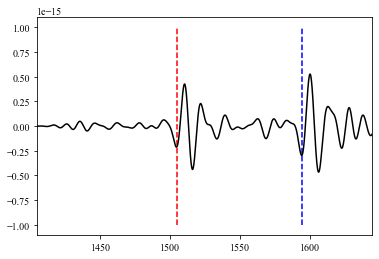

In [139]:
ylim=1*10**-15
time = st[0].times(reftime=eq_time)
plt.plot(time,HHR,'k')
plt.vlines(x = arr_SKS,ymin=-ylim,ymax=ylim,color='r',ls='--')
plt.vlines(x = arr_SKKS,ymin=-ylim,ymax=ylim,color='b',ls='--')
plt.xlim(arr_SKS-100,arr_SKKS+50)

# for deg ~120 
# signal 30s noise 60s
# for SKS

In [152]:
signalbegin = arr_SKS -5
signalend   = arr_SKS +25
noiseend    = arr_SKS -20 
noisebegin  = arr_SKS -20-60

Text(0, 0.5, 'Amplitude (m/s)')

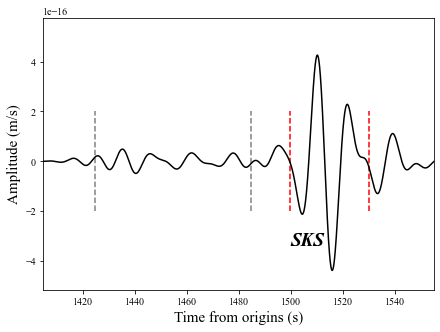

In [142]:
ylim=2*10**-16
time = st[0].times(reftime=eq_time)
plt.figure(figsize=(7,5))
plt.rcParams["font.family"] = "Times New Roman"
# plt.vlines(x = arr_SKS,ymin=-4*10**-6,ymax=4*10**-6,color='r',ls='--')
plt.vlines(x = signalbegin,ymin=-ylim,ymax=ylim,color='r',ls='--')
plt.vlines(x = signalend,ymin=-ylim,ymax=ylim,color='r',ls='--')
plt.vlines(x = noiseend,ymin=-ylim,ymax=ylim, color='grey',ls='--')
plt.vlines(x = noisebegin,ymin=-ylim,ymax=ylim,color='grey',ls='--')
plt.plot(time,HHR,'k')
plt.text(x = signalbegin, y = -ylim*1.7, s = 'SKS', fontsize=19, fontstyle= 'italic', fontweight='bold')
plt.xlim(arr_SKS-100,arr_SKS+50)

plt.xlabel('Time from origins (s)', fontsize=15)
plt.ylabel('Amplitude (m/s)', fontsize=15)

In [153]:
dt = st[0].stats.sampling_rate
temp_tr = Trace(data=HHR)
temp_tr.stats.delta = 1/dt
temp_tr.stats.starttime = st[0].stats.starttime
signal = temp_tr.slice(starttime=eq_time+signalbegin ,endtime = eq_time+signalend)
noise = temp_tr.slice(eq_time+noisebegin,eq_time+noiseend)


signal_envelope = envelope(signal.data)
noise_envelope = envelope(noise.data)

cal_signal = sum(signal_envelope**2)
cal_noise = sum(noise_envelope**2)

SNR = cal_signal * 2 / cal_noise
print(round(SNR,0))

90.0


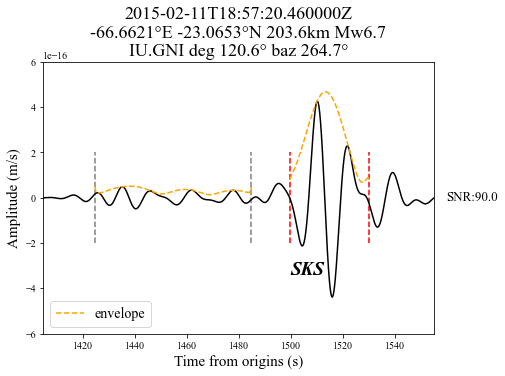

In [154]:
time = st[0].times(reftime=eq_time)
ylim=2*10**-16
plt.figure(figsize=(7,5))
plt.rcParams["font.family"] = "Times New Roman"


plt.title(f'{eq_time}\n{eq_lon}°E {eq_lat}°N {depth}km Mw{Cata[0].magnitudes[0].mag}\nIU.GNI deg {round(deg,1)}° baz {round(baz,1)}°', fontsize=18)
# plt.vlines(x = arr_SKS,ymin=-4*10**-6,ymax=4*10**-6,color='r',ls='--')
plt.vlines(x = signalbegin,ymin=-ylim,ymax=ylim,color='r',ls='--')
plt.vlines(x = signalend,ymin=-ylim,ymax=ylim,color='r',ls='--')
plt.vlines(x = noiseend,ymin=-ylim,ymax=ylim,color='grey',ls='--')
plt.vlines(x = noisebegin,ymin=-ylim,ymax=ylim,color='grey',ls='--')
plt.plot(time,HHR,'k')
plt.plot(signal.times(reftime=eq_time),signal_envelope,c='orange',ls='--', label='envelope')
plt.plot(noise.times(reftime=eq_time),noise_envelope,c='orange',ls='--')

plt.xlim(arr_SKS-100,arr_SKS+50)
plt.text(x = signalbegin, y = -ylim*1.7, s = 'SKS', fontsize=19, fontstyle= 'italic', fontweight='bold')
plt.xlabel('Time from origins (s)', fontsize=15)
plt.ylabel('Amplitude (m/s)', fontsize=15)
plt.legend(fontsize=14, loc=3)
plt.text(x=arr_SKS+55, y= 0, s=f'SNR:{round(SNR,0)}', va='center',ha='left', fontsize=13)
plt.ylim(-ylim*3,ylim*3)
plt.savefig('SNR_SKS.png',dpi=200, bbox_inches='tight')
plt.savefig('SNR_SKS.pdf', bbox_inches='tight')


# for SKKS

In [145]:
### noise same as SKS, change signal window to SKKS
signalbegin = arr_SKKS -5
signalend   = arr_SKKS +25
noiseend    = arr_SKS -20 
noisebegin  = arr_SKS -20-60

(1405.1416510968188, 1655.1416510968188)

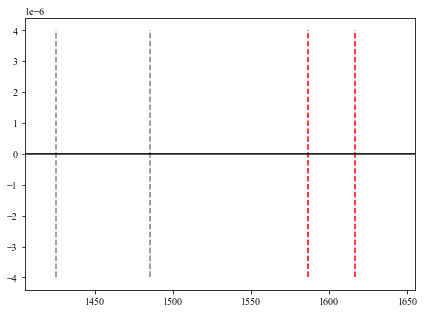

In [119]:
time = st[0].times(reftime=eq_time)
ylim=0.5*10**-15
plt.figure(figsize=(7,5))
plt.rcParams["font.family"] = "Times New Roman"
# plt.vlines(x = arr_SKS,ymin=-4*10**-6,ymax=4*10**-6,color='r',ls='--')
plt.vlines(x = signalbegin,ymin=-4*10**-6,ymax=4*10**-6,color='r',ls='--')
plt.vlines(x = signalend,ymin=-4*10**-6,ymax=4*10**-6,color='r',ls='--')
plt.vlines(x = noiseend,ymin=-4*10**-6,ymax=4*10**-6,color='grey',ls='--')
plt.vlines(x = noisebegin,ymin=-4*10**-6,ymax=4*10**-6,color='grey',ls='--')
plt.plot(time,HHR,'k')
plt.xlim(arr_SKS-100,arr_SKS+150)

In [146]:
dt = st[0].stats.sampling_rate
temp_tr = Trace(data=HHR)
temp_tr.stats.delta = 1/dt
temp_tr.stats.starttime = st[0].stats.starttime
signal = temp_tr.slice(starttime=eq_time+signalbegin ,endtime = eq_time+signalend)
noise = temp_tr.slice(eq_time+noisebegin,eq_time+noiseend)


signal_envelope = envelope(signal.data)
noise_envelope = envelope(noise.data)

cal_signal = sum(signal_envelope**2)
cal_noise = sum(noise_envelope**2)

SNR = cal_signal * 2 / cal_noise
print(round(SNR,0))

130.0


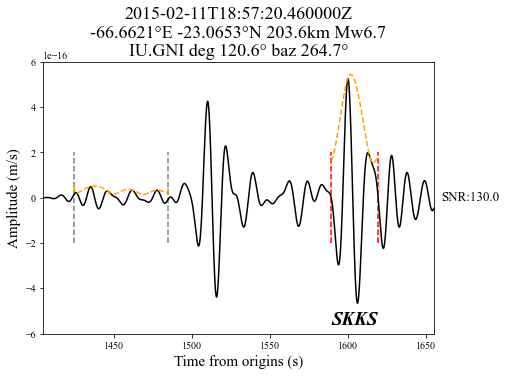

In [150]:
ylim=2*10**-16
plt.figure(figsize=(7,5))
plt.rcParams["font.family"] = "Times New Roman"
plt.title(f'{eq_time}\n{eq_lon}°E {eq_lat}°N {depth}km Mw{Cata[0].magnitudes[0].mag}\nIU.GNI deg {round(deg,1)}° baz {round(baz,1)}°', fontsize=18)
time = st[0].times(reftime=eq_time)
# plt.vlines(x = arr_SKS,ymin=-4*10**-6,ymax=4*10**-6,color='r',ls='--')
plt.vlines(x = signalbegin,ymin=-ylim,ymax=ylim,color='r',ls='--')
plt.vlines(x = signalend,ymin=-ylim,ymax=ylim,color='r',ls='--')
plt.vlines(x = noiseend,ymin=-ylim,ymax=ylim,color='grey',ls='--')
plt.vlines(x = noisebegin,ymin=-ylim,ymax=ylim,color='grey',ls='--')
plt.plot(time,HHR,'k')
plt.plot(signal.times(reftime=eq_time),signal_envelope,c='orange',ls='--')
plt.plot(noise.times(reftime=eq_time),noise_envelope,c='orange',ls='--')

plt.ylim(-ylim*3,ylim*3)
plt.xlim(arr_SKS-100,arr_SKS+150)
plt.text(x = signalbegin, y = -ylim*2.8, s = 'SKKS', fontsize=19, fontstyle= 'italic', fontweight='bold')
plt.xlabel('Time from origins (s)', fontsize=15)
plt.ylabel('Amplitude (m/s)', fontsize=15)
# plt.legend(fontsize=14, loc=3)
plt.text(x=arr_SKS+155, y= 0, s=f'SNR:{round(SNR,0)}', va='center',ha='left', fontsize=13)

plt.savefig('SNR_SKKS.png',dpi=200,  bbox_inches='tight')
plt.savefig('SNR_SKKS.pdf',bbox_inches='tight')

# for deg ~120 
# Signal 25 Noise 50 
# for SKS

In [103]:
signalbegin = arr_SKS -3
signalend   = arr_SKS +22
noiseend    = arr_SKS -20
noisebegin  = arr_SKS -20 -50

(1404.8468663575109, 1654.8468663575109)

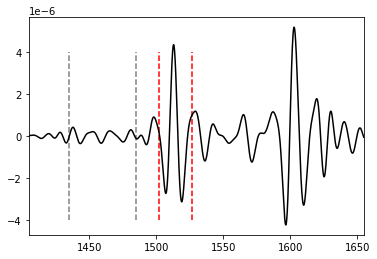

In [30]:
time = st[0].times(reftime=eq_time)
# plt.vlines(x = arr_SKS,ymin=-4*10**-6,ymax=4*10**-6,color='r',ls='--')
plt.vlines(x = signalbegin,ymin=-4*10**-6,ymax=4*10**-6,color='r',ls='--')
plt.vlines(x = signalend,ymin=-4*10**-6,ymax=4*10**-6,color='r',ls='--')
plt.vlines(x = noiseend,ymin=-4*10**-6,ymax=4*10**-6,color='grey',ls='--')
plt.vlines(x = noisebegin,ymin=-4*10**-6,ymax=4*10**-6,color='grey',ls='--')
plt.plot(time,HHR,'k')
plt.xlim(arr_SKS-100,arr_SKS+150)

In [32]:
dt = st[0].stats.sampling_rate
temp_tr = Trace(data=HHR)
temp_tr.stats.delta = 1/dt
temp_tr.stats.starttime = st[0].stats.starttime
signal = temp_tr.slice(starttime=eq_time+signalbegin ,endtime = eq_time+signalend)
noise = temp_tr.slice(eq_time+noisebegin,eq_time+noiseend)

signal_envelope = envelope(signal.data)
noise_envelope = envelope(noise.data)

cal_signal = sum(signal_envelope**2)
cal_noise = sum(noise_envelope**2)

SNR = cal_signal * 2 / cal_noise
print(SNR)

106.095011269


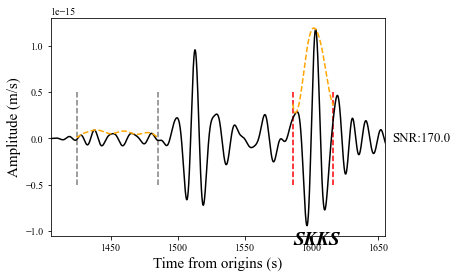

In [92]:
time = st[0].times(reftime=eq_time)
# plt.vlines(x = arr_SKS,ymin=-4*10**-6,ymax=4*10**-6,color='r',ls='--')
plt.vlines(x = signalbegin,ymin=-ylim,ymax=ylim,color='r',ls='--')
plt.vlines(x = signalend,ymin=-ylim,ymax=ylim,color='r',ls='--')
plt.vlines(x = noiseend,ymin=-ylim,ymax=ylim,color='grey',ls='--')
plt.vlines(x = noisebegin,ymin=-ylim,ymax=ylim,color='grey',ls='--')
plt.plot(time,HHR,'k')
plt.plot(signal.times(reftime=eq_time),signal_envelope,c='orange',ls='--')
plt.plot(noise.times(reftime=eq_time),noise_envelope,c='orange',ls='--')

plt.xlim(arr_SKS-100,arr_SKS+150)
plt.text(x = signalbegin, y = -ylim*2.3, s = 'SKKS', fontsize=19, fontstyle= 'italic', fontweight='bold')
plt.xlabel('Time from origins (s)', fontsize=15)
plt.ylabel('Amplitude (m/s)', fontsize=15)
# plt.legend(fontsize=14, loc=3)
plt.text(x=arr_SKS+155, y= 0, s=f'SNR:{round(SNR,0)}', va='center',ha='left', fontsize=13)

plt.savefig('SNR_SKKS.png',dpi=200)
plt.savefig('SNR_SKKS.pdf')

# for SKKS

In [21]:
### noise same as SKS, change signal window to SKKS
signalbegin = arr_SKKS -3
signalend   = arr_SKKS +22
noiseend    = arr_SKS -20
noisebegin  = arr_SKS -20 -50

(1405.1416510968188, 1655.1416510968188)

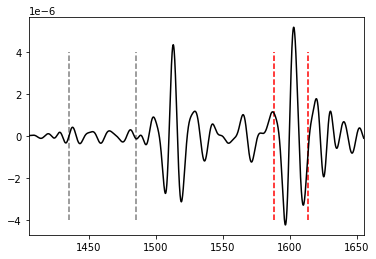

In [22]:
time = st[0].times(reftime=eq_time)
# plt.vlines(x = arr_SKS,ymin=-4*10**-6,ymax=4*10**-6,color='r',ls='--')
plt.vlines(x = signalbegin,ymin=-4*10**-6,ymax=4*10**-6,color='r',ls='--')
plt.vlines(x = signalend,ymin=-4*10**-6,ymax=4*10**-6,color='r',ls='--')
plt.vlines(x = noiseend,ymin=-4*10**-6,ymax=4*10**-6,color='grey',ls='--')
plt.vlines(x = noisebegin,ymin=-4*10**-6,ymax=4*10**-6,color='grey',ls='--')
plt.plot(time,HHR,'k')
plt.xlim(arr_SKS-100,arr_SKS+150)

In [23]:
dt = st[0].stats.sampling_rate
temp_tr = Trace(data=HHR)
temp_tr.stats.delta = 1/dt
temp_tr.stats.starttime = st[0].stats.starttime
signal = temp_tr.slice(starttime=eq_time+signalbegin ,endtime = eq_time+signalend)
noise = temp_tr.slice(eq_time+noisebegin,eq_time+noiseend)

signal_envelope = envelope(signal.data)
noise_envelope = envelope(noise.data)

cal_signal = sum(signal_envelope**2)
cal_noise = sum(noise_envelope**2)

SNR = cal_signal * 2 / cal_noise
print(SNR)

175.883299423


(1405.1416510968188, 1655.1416510968188)

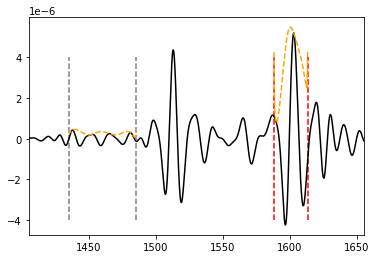

In [24]:
time = st[0].times(reftime=eq_time)
# plt.vlines(x = arr_SKS,ymin=-4*10**-6,ymax=4*10**-6,color='r',ls='--')
plt.vlines(x = signalbegin,ymin=-4*10**-6,ymax=4*10**-6,color='r',ls='--')
plt.vlines(x = signalend,ymin=-4*10**-6,ymax=4*10**-6,color='r',ls='--')
plt.vlines(x = noiseend,ymin=-4*10**-6,ymax=4*10**-6,color='grey',ls='--')
plt.vlines(x = noisebegin,ymin=-4*10**-6,ymax=4*10**-6,color='grey',ls='--')
plt.plot(time,HHR,'k')
plt.plot(signal.times(reftime=eq_time),signal_envelope,c='orange',ls='--')
plt.plot(noise.times(reftime=eq_time),noise_envelope,c='orange',ls='--')

plt.xlim(arr_SKS-100,arr_SKS+150)